<h1 style="text-align:center"> Instacart Market Basket Analysis</h1>

This notebook will serve as the analysis of the Instacart data. <br>
This is a competition hosted by Kaggle and the files can be found in the following link: https://www.kaggle.com/c/instacart-market-basket-analysis/data <br>
Instacart is an on-demand grocery delivery platform facilitating doorstep deliveries of groceries and other home essentials in major cities of USA. <br>
In this competition, Instacart is challenging the Kaggle community to use this anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order. They’re not only looking for the best model, Instacart’s also looking for machine learning engineers to grow their team.

<h3 style="text-align:center"> Load Libraries</h3>

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization tools
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Display centered plots

In [37]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h3 style="text-align:center">Load Data</h3>

In [2]:
# List of products and relative information (product_id, aisle_id, department_id)
products = pd.read_csv('data/products.csv')

# This file tells to which set (prior, train, test) an order belongs
orders = pd.read_csv('data/orders.csv') 

train_orders = pd.read_csv('data/order_products__train.csv')
prior_orders = pd.read_csv('data/order_products__prior.csv')

# File that assign department_id to department name
dpmt = pd.read_csv('data/departments.csv')

# List of the different aisles (aisle_id -> aisle )
aisle = pd.read_csv('data/aisles.csv')

Interestingly enough, the test set of orders is not explicitely provided as one would expect when looking at train_orders and prior_orders.<br>
Hence, we have to make ourselves the dataframe for orders belonging to the test set.

In [3]:
test_orders = orders.loc[orders['eval_set'] == 'test', :]

<h3 style="text-align:center">Data Analysis</h3>

In [4]:
# Shape of dataframes
print("products shape:", products.shape)
print("orders shape:", orders.shape)
print("train_orders shape:", train_orders.shape)
print("prior_orders shape:", prior_orders.shape)
print("test_orders shape:", test_orders.shape)
print("departments shape:", dpmt.shape)
print("aisles shape", aisle.shape)

products shape: (49688, 4)
orders shape: (3421083, 7)
train_orders shape: (1384617, 4)
prior_orders shape: (32434489, 4)
test_orders shape: (75000, 7)
departments shape: (21, 2)
aisles shape (134, 2)


We are expected to predict the products chosen of 75000 orders. 

Next we look for for missing values in each of the dataframes.

In [5]:
print("Missing values in produts:", products.isnull().sum().sum())
print("Missing values in orders:", orders.isnull().sum().sum())
print("Missing values in train_orders:", train_orders.isnull().sum().sum())
print("Missing values in prior_orders:", prior_orders.isnull().sum().sum())
print("Missing values in test_orders:", test_orders.isnull().sum().sum())

Missing values in produts: 0
Missing values in orders: 206209
Missing values in train_orders: 0
Missing values in prior_orders: 0
Missing values in test_orders: 0


Further investigation in orders is needed.

In [6]:
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

There are only missing values in the days_since_prior_order feature of the orders dataframe amongst the several files provided.

Check the first 5 values of the different files.

In [18]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


<u>Understanding eval_set</u>

There are 3 evaluation sets: 'prior', 'train', 'test'. <br>
'prior' refers to customers who had already bought from Instacart before, hence they have a user_id.
'prior' can be found several times from the same user, it just means that multiple previous orders are recorded.<br>
Most importantly, these user classified in the 'prior' evaluation set have <b>either</b> a train or test label.<br>
We need to separate the "true" test and test set from this valuable information.

In [66]:
# an example to understand visually how the problem is structured
orders.loc[ orders['user_id'] == 1, :]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [17]:
train_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [19]:
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [20]:
test_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [21]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


<h3 style="text-align:center">Data Exploration</h3>

<u>Orders by hour</u>

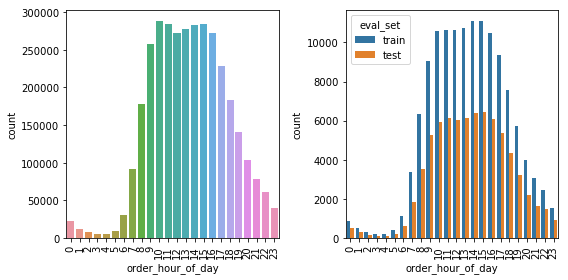

In [62]:
fig, ax = plt.subplots(ncols=2, sharey=False)

plt.xticks(rotation=90)

s1 = sns.countplot(x='order_hour_of_day',\
                   ax=ax[0],\
                   data=orders)

orders_train_test = orders.loc[(orders['eval_set'] == 'train') | (orders['eval_set'] == 'test'), \
                               ['order_hour_of_day', 'eval_set']]

s2 = sns.countplot(x='order_hour_of_day',\
                   ax=ax[1],\
                   hue='eval_set',\
                   data=orders_train_test)

# ax[1].set_xlabel('Hour of the day')
# fig.ylabel("number of orders")

# plt.xlabel('Hour of the day')
# plt.ylabel('Number of orders')

fig.set_size_inches(8, 4)

# Apply rotate to all plots
for label in ax[0].get_xmajorticklabels() + ax[1].get_xmajorticklabels():
    label.set_rotation(90)

# Set space between the plots
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    
plt.show()

We observe that 10am is the peak hour, and during the day from 10am to 5pm are the busiest hours. <br>
The train and test set seems to follow this trend. 

<u>Order by day of week (dow)</u>

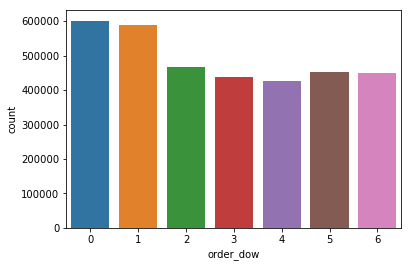

In [64]:
sns.countplot(x='order_dow',\
             data=orders)